이런것도 EDA라고 부르는 건지 모르겠지만 올려보겠습니다,,   
많이 부족하지만 잘 부탁드립니다...ㅎㅎ

## 이 EDA를 한 이유
- 'holidays' 데이터도 sales에 영향을 줄 것이다.
- 하지만 holiday는 지역적인 값이라서, 특정 지역의 store에만 작용할 것이다.
- 모델 학습을 시킬 때 이를 반영시키면 더 좋은 성능이 나올지도 모르겠으나, 문제는 'store' table의 'city', 'state'가 코드로 되어 있는 반면, 'holidays' 데이터의 'locale_name'은 코드가 아닌 이름으로 되어 있고 이를 매칭시키는 데이터가 전무하다.
- 주어진 데이터를 이용하여 store.city 혹은 store.state와 holidays.locale_name을 매칭시킬 수는 없을까?

## 본론
### 0. 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

BASE_DIR = '../input/devkor-sales-prediction'
train = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
store = pd.read_csv(os.path.join(BASE_DIR, 'store.csv'))
holidays = pd.read_csv(os.path.join(BASE_DIR, 'holidays.csv'))
oil = pd.read_csv(os.path.join(BASE_DIR, 'oil.csv'))
transactions = pd.read_csv(os.path.join(BASE_DIR, 'transactions.csv'))

In [2]:
# cudf로 바꾸기
import cudf

gtrain = cudf.from_pandas(train)
gstore = cudf.from_pandas(store)
gholidays = cudf.from_pandas(holidays)
goil = cudf.from_pandas(oil)
gtransactions = cudf.from_pandas(transactions)

In [3]:
# sales = 0인 tuple drop
idx = gtrain.loc[gtrain['sales'] == 0].index
gtrain.drop(idx, axis=0, inplace=True)

In [4]:
# attribute 추가

train_data_ = gtrain.merge(gtransactions, how="left", on=["date", "store_id"])
train_data_.rename(columns = {"store_id_x": "store_id"}, inplace = True)

goil = goil.dropna()
train_data_ = train_data_.merge(goil, how="left", on="date")

gstore = gstore.dropna()
train_data_ = train_data_.merge(gstore, how="left", on="store_id")

In [5]:
train_data_

,id,date,store_id,product_type,sales,onpromotion,transactions,dcoilwtico,city,state,type,cluster
0,110168,2013-03-03,5,HARDWARE,1.000,0,1513,<NA>,C02,S02,D,4
1,110171,2013-03-03,5,HOME APPLIANCES,1.000,0,1513,<NA>,C02,S02,D,4
2,110186,2013-03-03,5,SEAFOOD,17.299,0,1513,<NA>,C02,S02,D,4
3,110187,2013-03-03,50,AUTOMOTIVE,21.000,0,3496,<NA>,C09,S08,A,14
4,110178,2013-03-03,5,MEATS,387.697,0,1513,<NA>,C02,S02,D,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2038926,2955310,2017-07-21,3,POULTRY,1587.276,42,3413,45.78,C01,S01,D,8
2038927,2970473,2017-07-29,6,FROZEN FOODS,241.363,1,1978,<NA>,C01,S01,D,13
2038928,2955305,2017-07-21,3,MAGAZINES,41.000,0,3413,45.78,C01,S01,D,8
2038929,2970489,2017-07-29,6,PLAYERS AND ELECTRONICS,14.000,0,1978,<NA>,C01,S01,D,13


In [6]:
# holidays 데이터 정제 -> 대체 공휴일이 된 날은 holiday 날짜를 대체 공휴일로 대체.
# transferred=True인 data drop
idx = gholidays.loc[gholidays['transferred'] == True].index
holidays_notrns = gholidays.drop(idx, axis=0)

In [7]:
holidays_notrns = holidays_notrns.to_pandas()
holidays_notrns

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


### 1. Choose between 'city' and 'state'

In [8]:
print(f"locale name: {len(holidays_notrns['locale_name'].unique())}")
print(f"city: {len(store['city'].unique())}")
print(f"state: {len(store['state'].unique())}")

locale name: 24
city: 22
state: 16


city와 locale_name의 수가 비슷하므로 이 둘을 매핑시켜야겠다.

In [9]:
holidays_notrns['locale_name'].value_counts()

Ecuador                           166
Riobamba                           12
Quito                              12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          10
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Ibarra                              6
Manta                               6
Esmeraldas                          6
Cotopaxi                            6
El Carmen                           6
Santo Domingo                       6
Machala                             6
Imbabura                            6
Puyo                                6
Libertad                            6
Cuenca                              6
Cayambe                             6
Name: locale_name, dtype: int64

Ecuador의 데이터 수가 절대적으로 많으므로 이를 고려하여 추측하자.

## 2. How do we get hints from data? - Change points
- 시계열 데이터에서 중요하게 다뤄지는?(사실 잘 모름) change points를 이용
- date-sales 배열에서 공휴일을 예측
- 이를 holidays table과 대조 -> 특정 city가 어떤 locale_name을 가지고 있는지 어느 정도 예측 가능
- 라이브러리 Changefinder 이용 (자세한 사항은 구글링)

In [10]:
# 우선, product 종류 구분을 하지 않을 것이므로 그 컬럼의 값들을 다 합친다.
group_data = train_data_.to_pandas().groupby(['date', 'store_id', 'city'], as_index=False)[['sales']].sum()
group_data

,date,store_id,city,sales
0,2013-01-01,25,C11,2511.618999
1,2013-01-02,1,C01,7417.148000
2,2013-01-02,2,C01,10266.718981
3,2013-01-02,3,C01,24060.348000
4,2013-01-02,4,C01,10200.083980
...,...,...,...,...
82791,2017-07-31,50,C09,21258.423000
82792,2017-07-31,51,C10,22751.888000
82793,2017-07-31,52,C21,21818.138000
82794,2017-07-31,53,C21,11274.012000


In [11]:
!pip install changefinder

  Preparing metadata (setup.py) ... - done
  Created wheel for changefinder: filename=changefinder-0.3-py3-none-any.whl size=3841 sha256=60842161180b9d1d682f51d053614a000f86de8d0fb6207bb6bd6e8d72fa14f7
  Stored in directory: /root/.cache/pip/wheels/48/8f/4c/ba040e4cad3dbf0409c5c38ac9d3f92f947ea490412cdf3400
Successfully built changefinder


In [12]:
import changefinder

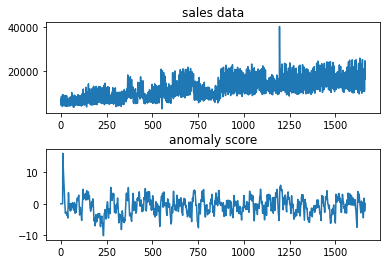

In [13]:
data = group_data.loc[group_data['city'] == "C12"]['sales'].tolist()
# Changepoint detection with the Pelt search method
f, (ax1, ax2) = plt.subplots(2, 1)
f.subplots_adjust(hspace=0.4)
ax1.plot(data)
ax1.set_title("sales data")

cf = changefinder.ChangeFinder()
scores = [cf.update(p) for p in data]
ax2.plot(scores)
ax2.set_title("anomaly score")
plt.show()

scores 배열의 값들은 date마다 부여되는 이상치(anomaly)를 뜻한다. 높을 수록 change point가 될 확률이 높다.. 고 해석하면 될듯?

In [14]:
# group_data에서 date, city만 추출해 scores와 합쳐주는 작업
date_frame = group_data.loc[group_data['city'] == "C12" , ['date', 'city']]
scores_series = pd.Series(scores, name='changePoint_scores')
scores_series.index = date_frame.index

group_data['changePoint_scores'] = scores_series
group_data.loc[group_data['city'] == 'C12']

,date,store_id,city,sales,changePoint_scores
24,2013-01-02,27,C12,7207.547000,0.000000
70,2013-01-03,27,C12,4387.566000,0.000000
116,2013-01-04,27,C12,4586.466001,0.000000
162,2013-01-05,27,C12,6731.607015,0.000000
208,2013-01-06,27,C12,8491.491000,0.000000
...,...,...,...,...,...
82552,2017-07-27,27,C12,10624.732000,-0.921251
82606,2017-07-28,27,C12,11914.659000,-2.341251
82660,2017-07-29,27,C12,17779.700000,-1.734038
82714,2017-07-30,27,C12,24531.335000,-0.637632


In [15]:
# score 값을 threshold하여 남은 값(date)을 holiday의 후보로 본다.
# date_frame table의 날짜와 holidays의 날짜와 join하여 후보가 실제 holiday인지 판단한다.
cond1 = group_data['city'] == 'C12'
cond2 = group_data['changePoint_scores'] > 5
if_holidays = group_data.loc[cond1 & cond2]

holidays_merge = holidays_notrns.merge(if_holidays[['date', 'city', 'changePoint_scores']], how='left', on='date')
holidays_merge.loc[holidays_merge['city'] == 'C12']

,date,type,locale,locale_name,description,transferred,city,changePoint_scores
219,2016-04-19,Event,National,Ecuador,Terremoto Manabi+3,False,C12,5.170711
220,2016-04-20,Event,National,Ecuador,Terremoto Manabi+4,False,C12,5.141771
221,2016-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,C12,5.417275
222,2016-04-21,Event,National,Ecuador,Terremoto Manabi+5,False,C12,5.417275
223,2016-04-22,Event,National,Ecuador,Terremoto Manabi+6,False,C12,5.646392
224,2016-04-23,Event,National,Ecuador,Terremoto Manabi+7,False,C12,5.838713
225,2016-04-24,Event,National,Ecuador,Terremoto Manabi+8,False,C12,5.721273
226,2016-04-25,Event,National,Ecuador,Terremoto Manabi+9,False,C12,5.453572


threshold 값 = 5로 했을 때, 'Ecuador' 9개, 'Riobamba' 1개임을 볼 수 있다.   
'Ecuador'의 수도 고려할 때, city 'C12'는 locale_name 'Riobamba'와 'Ecuador' 중 하나라고 추측할 수 있다.

## 3. Make this function

In [16]:
def match_city_locale_name(group_data, holidays_notrns, city, threshold):
    data = group_data.loc[group_data['city'] == city]['sales'].tolist()
    # Changepoint detection with the Pelt search method
    f, (ax1, ax2) = plt.subplots(2, 1)
    f.subplots_adjust(hspace=0.4)
    ax1.plot(data)
    ax1.set_title("sales data")

    cf = changefinder.ChangeFinder()
    scores = [cf.update(p) for p in data]
    ax2.plot(scores)
    ax2.set_title("anomaly score")
    plt.show()

    date_frame = group_data.loc[group_data['city'] == city , ['date', 'city']]
    scores_series = pd.Series(scores, name='changePoint_scores')
    scores_series.index = date_frame.index

    group_data['changePoint_scores'] = scores_series
    group_data.loc[group_data['city'] == city]

    cond1 = group_data['city'] == city
    cond2 = group_data['changePoint_scores'] > threshold
    if_holidays = group_data.loc[cond1 & cond2]

    holidays_merge = holidays_notrns.merge(if_holidays[['date', 'city', 'changePoint_scores']], how='left', on='date')
    return holidays_merge.loc[holidays_merge['city'] == city]

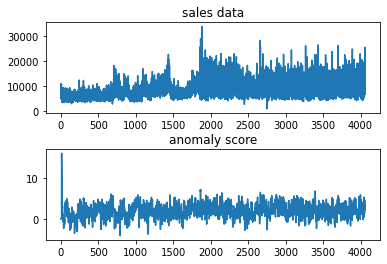

,date,type,locale,locale_name,description,transferred,city,changePoint_scores
180,2015-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,False,C02,7.104734
219,2016-04-19,Event,National,Ecuador,Terremoto Manabi+3,False,C02,6.132913
220,2016-04-19,Event,National,Ecuador,Terremoto Manabi+3,False,C02,6.503635


In [17]:
match_city_locale_name(group_data, holidays_notrns, 'C02', 6)

'Guayaquil'의 score 값이 가장 크므로, city 'C02'는 'Guayaquil'이라고 추측할 수 있다.

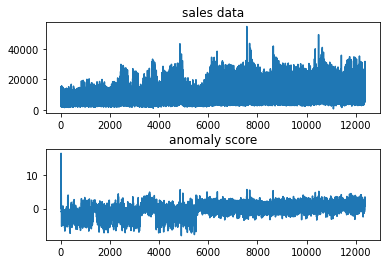

,date,type,locale,locale_name,description,transferred,city,changePoint_scores
197,2015-12-05,Additional,Local,Quito,Fundacion de Quito-1,False,C10,4.628471
217,2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False,C10,5.295874
218,2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False,C10,4.836842
219,2016-04-18,Event,National,Ecuador,Terremoto Manabi+2,False,C10,4.785925
282,2016-12-06,Holiday,Local,Quito,Fundacion de Quito,False,C10,4.895368
283,2016-12-06,Holiday,Local,Quito,Fundacion de Quito,False,C10,4.990833
284,2016-12-06,Holiday,Local,Quito,Fundacion de Quito,False,C10,5.081807


In [18]:
match_city_locale_name(group_data, holidays_notrns, 'C10', 4.5)

city 'C01'은 'Ecuador'와 'Quito' 중 하나라고 추측할 수 있다.

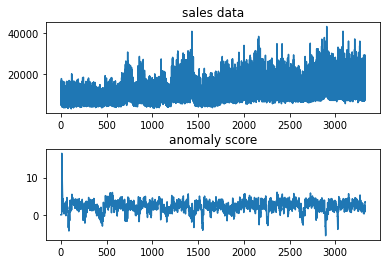

,date,type,locale,locale_name,description,transferred,city,changePoint_scores
69,2013-09-28,Holiday,Local,Ibarra,Fundacion de Ibarra,False,C09,5.240804
71,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,C09,5.994044
72,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,C09,5.428045
143,2014-12-01,Event,National,Ecuador,Cyber Monday,False,C09,5.238283
144,2014-12-01,Event,National,Ecuador,Cyber Monday,False,C09,5.612190
189,2015-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False,C09,5.659770
190,2015-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False,C09,5.382128
192,2015-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False,C09,5.201366
237,2016-05-02,Event,National,Ecuador,Terremoto Manabi+16,False,C09,5.008258
238,2016-05-02,Event,National,Ecuador,Terremoto Manabi+16,False,C09,5.568506


In [19]:
match_city_locale_name(group_data, holidays_notrns, 'C09', 5)

city 'C09'는 위에 열거된 값들 중 하나라고 추측할 수 있을 것이다. 너무 많은 게 문제지만...ㅎㅎ..

## 4. Further consideration
- 데이터의 불균형 해결 문제
- 여태까지는 score 값만 보고 감으로 추측을 했는데, correlation 등으로 수치화를 해서 판단할 순 없을까?
- 이것을 모델 학습에 어떻게 적용시킬까?